The goal of this tutorial is develop the reader's understanding of the theory underlying GridLAB-D operation.

The learning objectives for this turorial are

1. To understand how GridLAB-D works, and

2. To create simple GridLAB-D models using the GLM language.

The skills developed in this tutorial are the following:

1. Learn the GLM syntax for defining a class

2. Learn the GLM syntax for defining an object

3. Learn the shell syntax for running a simulation

4. Learn how to diagnose and fix simulation errors

# How GridLAB-D Works

GridLAB-D is an agent-based modeling and simulation environment that models systems as a collection of semi-independent entities called agents.  Each agent operates independently by assessing its situation and changing its state according to a set of rules.  Some of these rules are unique to each agent, while other rules may be associated with classes of agents. 

Agent usually execute rules in response to events that are generated by the simulation environment. These events help ensure state consistency for agents belonging to closely related classes, which are collected in modules.  For example, certain properties of electric power system agents must obey power flow laws such as Kirchoff's law and Telegan's law. All the agents that are contribute to solve the power flow problem are collected in classes belonging to the _powerflow_ module.  Events are generated by the simulation environment that are handled by powerflow classes help synchronize the states of electric power system agents.

To understand how object synchronization works, let us consider a very simple example problem such as computing the average value of a property of multiple agents. There are two parts to constructing this model. The first is the objects, and the second is the code.  The objects and the classes they belong to are presented in the GLM file, which also includes the linkage to the code, which is presented in a Python file.

The GLM file contains the following:
- a setting to enable all output from python code
- a **module** declaration to load the python code
- a **class** declaration to create a class for our object, which includes a single state variable *x*.
- an **object** declaration to create 100 objects of the class, which includes a random normal initial value for *x* and a link to the *sync* event handler in the python code.

In [1]:
!cat average_1.glm

#set suppress_repeat_messages=False
module average_1;
class example
{
	double x;
}
object example:..100
{
	x random.normal(0,1);
	on_sync python:average_1.sync;
}


The python code contains the following:
- the initial values of the global variable, include the list of objects, the accumulator for the average, and the counter for the average.
- the *on_init* simulation initialization event handler, which obtains a list of all the objects and outputs how many objects it found.  The return value **True** indicates that the initialization was successful.
- the *sync* object event handler, which increments the *y* and *n* values with the *x* value, and 1, respectively. The return value **gridlabd.NEVER** tells the simulation that this event does not given rise to any other event later.
- the *on_term* simulation termination event handler, which computes the final average value.

In [2]:
!cat average_1.py

def on_init(t):
	global object_list
	object_list = gridlabd.get("objects")
	gridlabd.output(f"{len(object_list)} objects found")
	global y
	global n
	y = 0.0
	n = 0
	return True

def sync(obj,t):
	global y
	global n
	y += float(gridlabd.get_value(obj,"x"))
	n += 1
	return gridlabd.NEVER

def on_term(t):
	if n > 0:
		gridlabd.output(f"average = {y/n}")
	gridlabd.output(f"n = {n}")


This example only initializes the value of *x* with random value.  If we want the value of *x* to change periodically to a new random value, we can change the definition of the class so it exhibits this behavior (1). In addition, we enable the simulation clock by defining the start and end time of the simulation (2), and we enable the generation of plot of the output data after the simulation is done (3).

In [3]:
!cat average_2.glm

#set suppress_repeat_messages=False
module average_2;
class example
{
	randomvar x;
}
object example:..100
{
	x "type:normal(0,1); refresh:1h"; // (1) update the random value every hour
	on_sync python:average_2.sync;
}

// (2) enable the simulation clock
clock
{
	starttime "2020-01-01 00:00:00";
	stoptime "2020-02-01 00:00:00";
}

// (3) generate a plot when the simulation completes successfully
#on_exit 0 gridlabd plot -i=average_2.csv --plot:x=datetime --plot:grid --plot:y=average --figure:tight_layout=True --plot:rot=90 --plot:title="Average" --plot:ylabel="Value" --plot:xlabel="Date/Time"

To enable event handling before the simulation clock updates, we add the *on_precommit* (1) and *on_commit* (2) event handlers to reset and update the average calculation each time the clock is synchronized. In addition, we change the *on_term* event handler to generate a pandas dataframe and save it to a CSV file that can be plotted by the `#on_exit` directive in the GLM file.

In [4]:
!cat average_2.py

def on_init(t):
	global object_list
	object_list = gridlabd.get("objects")
	gridlabd.output(f"{len(object_list)} objects found")
	global result
	result = {}
	return True

def on_precommit(t): # (1) reset accumulators
	global y
	global n
	y = 0.0
	n = 0
	return gridlabd.NEVER

def sync(obj,t):
	global y
	global n
	y += float(gridlabd.get_value(obj,"x"))
	n += 1
	return gridlabd.NEVER

def on_commit(t): # (2) update accumulators
	if n > 0:
		import datetime
		result[datetime.datetime.fromtimestamp(t)] = y/n
	return gridlabd.NEVER

def on_term(t): # (3) generate CSV output
	import pandas
	data = pandas.DataFrame(
		data = result.values(), 
		index = result.keys(), 
		columns = ["average"])
	data.index.name = "datetime"
	data.to_csv("average_2.csv")

The resulting plot is
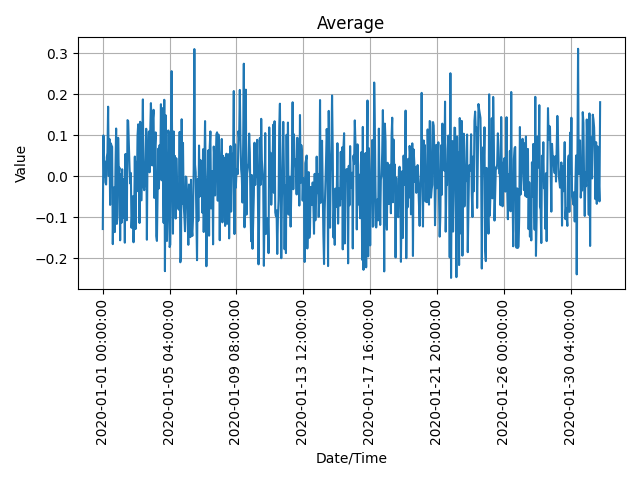

# Modeling with GLM

GridLAB-D allows modelers to define their own classes.  A class is a collection of properties described by variables, and behaviors described by event handlers.  For example, a class describing a tree might be as simple as the following:

**Skill 1(a)**: Defining a class requires one to specify both the important properties of a category of objects in a model.  Generally, the choice of properties is based on the requirements for the model.  If we want to model how susceptible a tree is to high wind, then `height`, `age`, and `type` may be very important properties, but `width` might not be.  However, if we want to model how susceptible a tree is to fire, then `width` and `stressed` may be important as well.  The choice of properties also requires consideration of whether and how one acquires the data required to populate a model.  The choice of dimensions (the units), representation (whether to use integer, real, or complex numbers, booleans, sets, enumeration, or text), and naming conventions are all important considerations as well.  Among GridLAB-D users, there are some conventions that are generally observed, which will become evident throughout the tutorials.  These include the following:
1. avoiding the use the acronyms, abbreviations, and domain-specific jargon;
2. specifying units whenever possible;
3. using lowercase for names and uppercase for constants;
4. being careful about how redundancy in what properties describe is addressed, e.g., allowing alternative ways of describing the same thing but being clear about what happens when both are provided but they don't agree; and
5. being clear about what the default is if the property is not required.

**Skill 1(b)**: Classes usually include behaviors to describe how object will respond to various events in the simulation. The following event handlers may be defined for any class you define:
- *init(obj,ts)*: called once for each object when it is initialized
- *precommit(obj,ts)*: called once for each object after the main clock is updated
- *presync(obj,ts)*: called repeatedly for each object before clock synchronization until all object clocks are synchronized
- *sync(obj,ts)*: called repeatedly for each object to synchronize the object's clock until all object clocks are synchronized
- *postsync(obj,ts)*: called repeatedly for each object after clock synchronization until all object clocks are synchronized
- *commit(obj,ts)*: called once for each object after clock synchronization on all clocks is completed
- *finalize(obj,ts)*: called once after the main clock is stopped.